In [161]:
#Imports

In [163]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [165]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [167]:
#paths

In [169]:
data_train_path = 'data/train'
data_val_path = 'data/validation'
data_test_path = 'data/test'
model_save_path = 'models/image_classify.keras'

In [171]:
img_width, img_height = 180, 180
batch_size = 32

In [173]:
data_train = tf.keras.utils.image_dataset_from_directory(
    data_train_path,
    shuffle=True,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    validation_split=False
)

Found 3115 files belonging to 36 classes.


In [175]:
data_cat = data_train.class_names
print(f"Classes found ({len(data_cat)}): {data_cat}")

Classes found (36): ['apple', 'banana', 'beetroot', 'bell pepper', 'cabbage', 'capsicum', 'carrot', 'cauliflower', 'chilli pepper', 'corn', 'cucumber', 'eggplant', 'garlic', 'ginger', 'grapes', 'jalepeno', 'kiwi', 'lemon', 'lettuce', 'mango', 'onion', 'orange', 'paprika', 'pear', 'peas', 'pineapple', 'pomegranate', 'potato', 'raddish', 'soy beans', 'spinach', 'sweetcorn', 'sweetpotato', 'tomato', 'turnip', 'watermelon']


In [177]:
data_val = tf.keras.utils.image_dataset_from_directory(
    data_val_path,
    shuffle=False,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    validation_split=False
)

Found 351 files belonging to 36 classes.


In [179]:
data_test = tf.keras.utils.image_dataset_from_directory(
    data_test_path,
    shuffle=False,
    image_size=(img_width, img_height),
    batch_size=batch_size,
    validation_split=False
)

Found 359 files belonging to 36 classes.


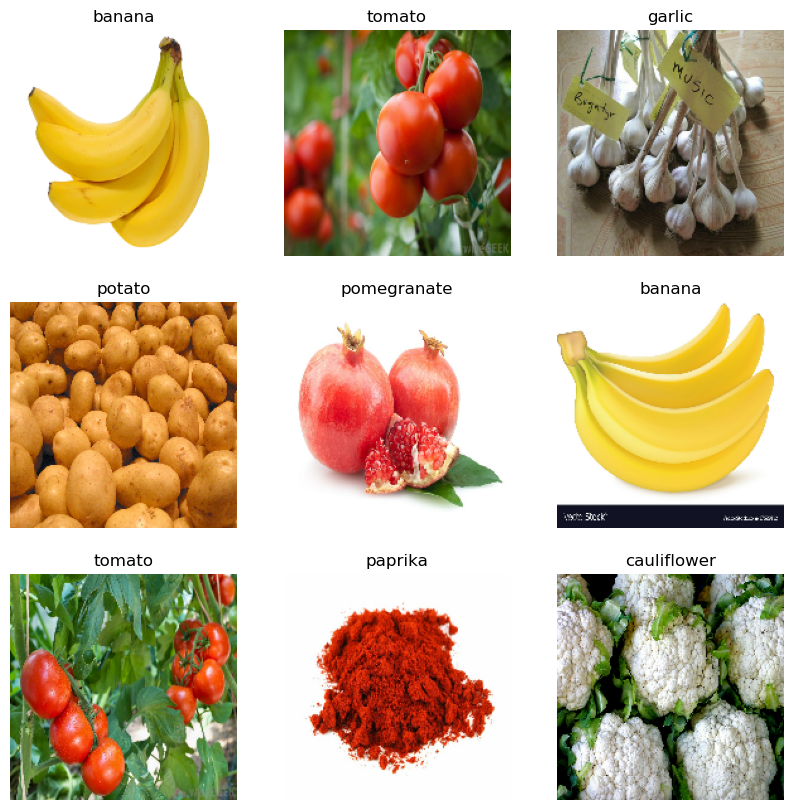

In [181]:
plt.figure(figsize=(10,10))
for images, labels in data_train.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(data_cat[labels[i]])
        plt.axis('off')
plt.show()

In [182]:
# Prefetch for performance optimization

In [183]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = data_train.prefetch(buffer_size=AUTOTUNE)
val_ds = data_val.prefetch(buffer_size=AUTOTUNE)
test_ds = data_test.prefetch(buffer_size=AUTOTUNE)

In [187]:
num_classes = len(data_cat)

In [189]:
print(f"Number of classes: {num_classes}")

Number of classes: 36


In [191]:
#Data Augmentation

In [193]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [195]:
#Model: Transfer Learning with MobileNetV2 

In [197]:
base_model = MobileNetV2(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = models.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

In [199]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_4 (Rescaling)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 6, 6, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ ?                           │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [201]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [203]:
#Callbacks

In [205]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint(model_save_path, save_best_only=True, monitor='val_loss')

In [207]:
#Train the Model

In [209]:
epochs = 25
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 114s 1s/step - accuracy: 0.2727 - loss: 2.8342 - val_accuracy: 0.8006 - val_loss: 0.6902
Epoch 2/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 77s 777ms/step - accuracy: 0.6774 - loss: 1.0584 - val_accuracy: 0.8547 - val_loss: 0.4763
Epoch 3/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 70s 701ms/step - accuracy: 0.7555 - loss: 0.7933 - val_accuracy: 0.8860 - val_loss: 0.3609
Epoch 4/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 80s 809ms/step - accuracy: 0.7735 - loss: 0.6757 - val_accuracy: 0.8946 - val_loss: 0.3235
Epoch 5/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 76s 764ms/step - accuracy: 0.8230 - loss: 0.5686 - val_accuracy: 0.8946 - val_loss: 0.3073
Epoch 6/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 72s 712ms/step - accuracy: 0.8352 - loss: 0.5149 - val_accuracy: 0.9202 - val_loss: 0.2828
Epoch 7/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 73s 734ms/step - accuracy: 0.8338 - loss: 0.4978 - val_accuracy: 0.9117 - val_loss: 0.2799
Epoch 8/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 70s 701ms/step - accuracy: 0.8602 - loss: 0.4095 - val_accura

In [211]:
#Plot Accuracy and Loss

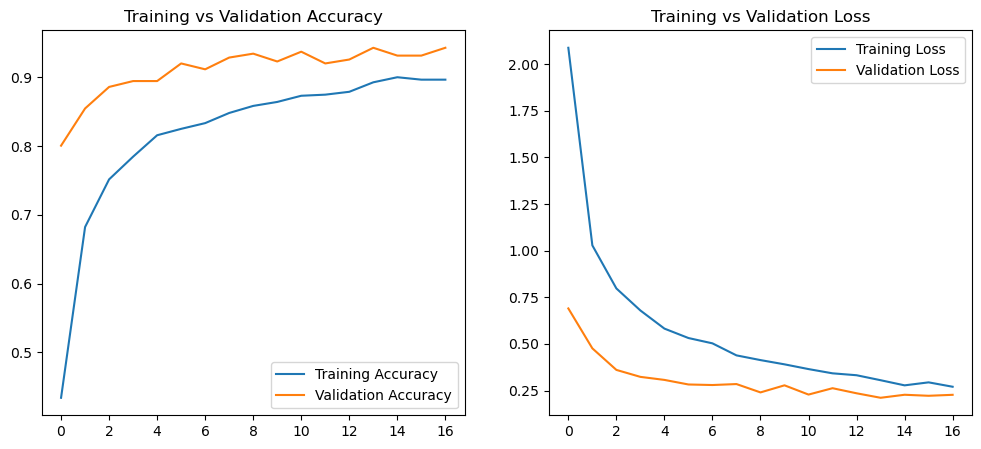

In [213]:
epochs_range = range(len(history.history['accuracy']))
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

In [215]:
#Evaluate on Test Set

In [217]:
test_images = []
test_labels = []
for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)

x_test = tf.concat(test_images, axis=0)
y_test = tf.concat(test_labels, axis=0)

pred_logits = model.predict(x_test)
y_pred = np.argmax(pred_logits, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 13s 905ms/step


In [218]:
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=data_cat))

Classification Report:
               precision    recall  f1-score   support

        apple       0.50      0.50      0.50        10
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       0.62      1.00      0.77        10
      cabbage       1.00      1.00      1.00        10
     capsicum       1.00      0.50      0.67        10
       carrot       1.00      0.90      0.95        10
  cauliflower       1.00      1.00      1.00        10
chilli pepper       1.00      1.00      1.00        10
         corn       0.82      0.90      0.86        10
     cucumber       0.91      1.00      0.95        10
     eggplant       1.00      1.00      1.00        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00        10
     jalepeno       1.00      0.90      0.95        10
         kiwi       1.00      1.00      1

In [219]:
#Confusion Matrix Plot

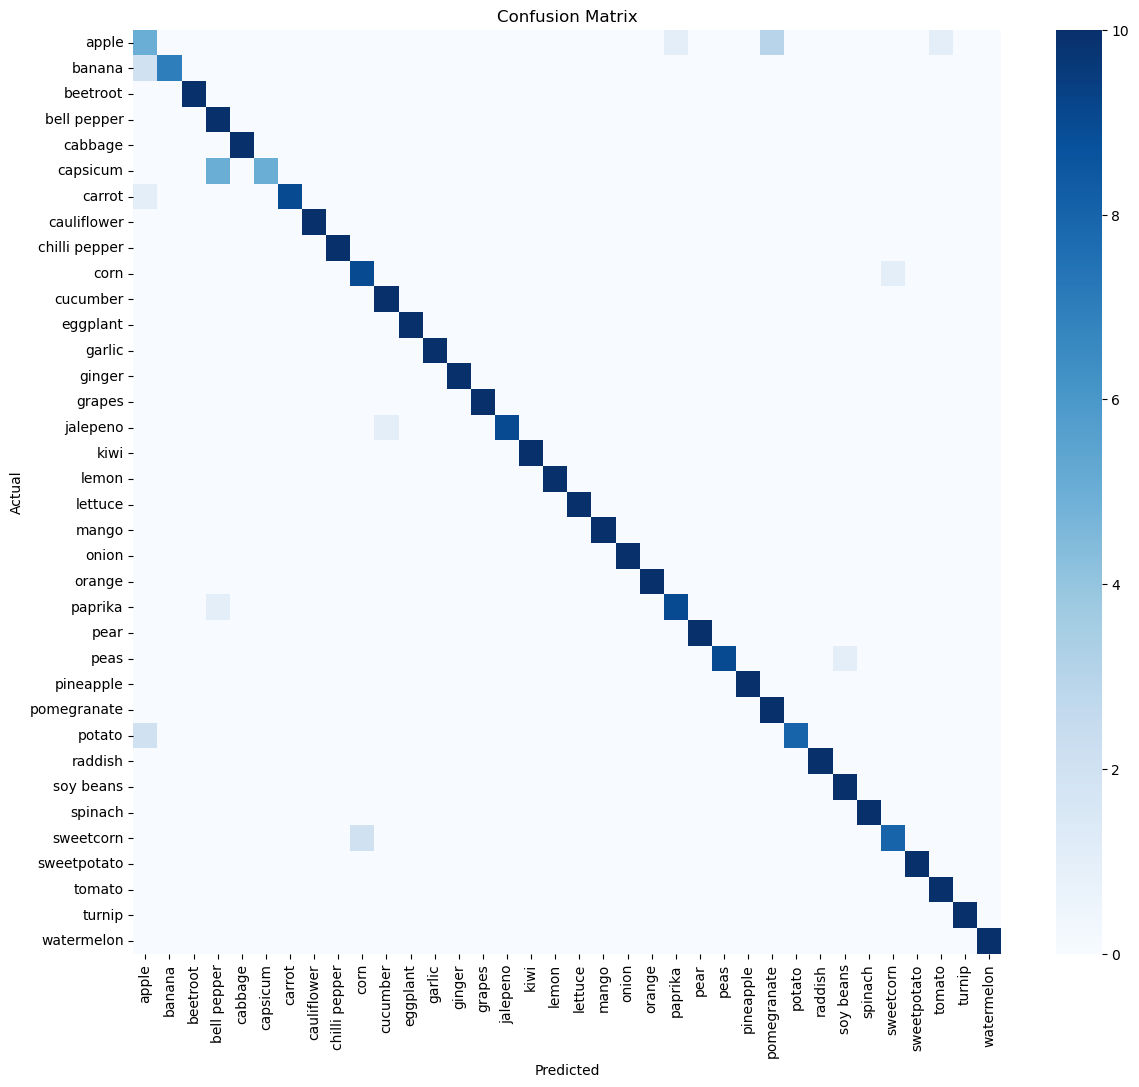

In [220]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(14,12))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
            xticklabels=data_cat, yticklabels=data_cat)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [225]:
#Save the Model

In [227]:
model.save(model_save_path)

In [229]:
#Example Inference on a Single Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step


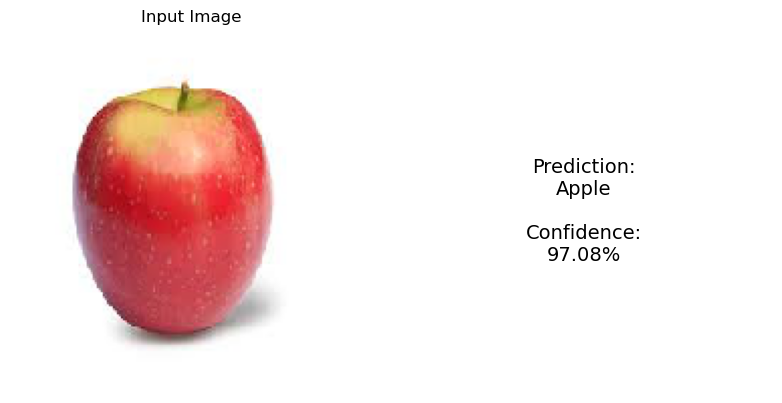

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


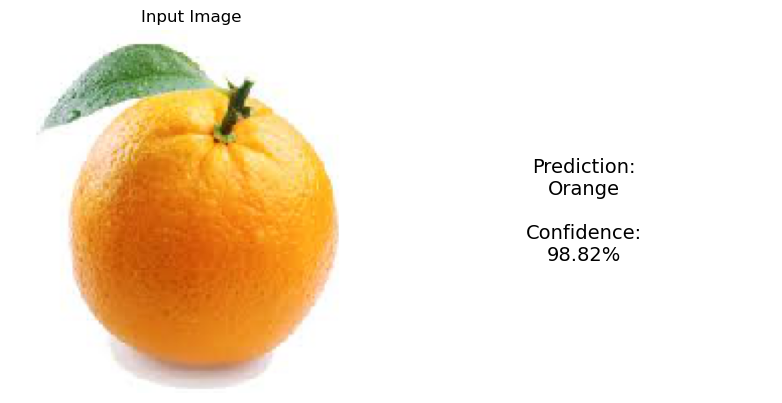

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


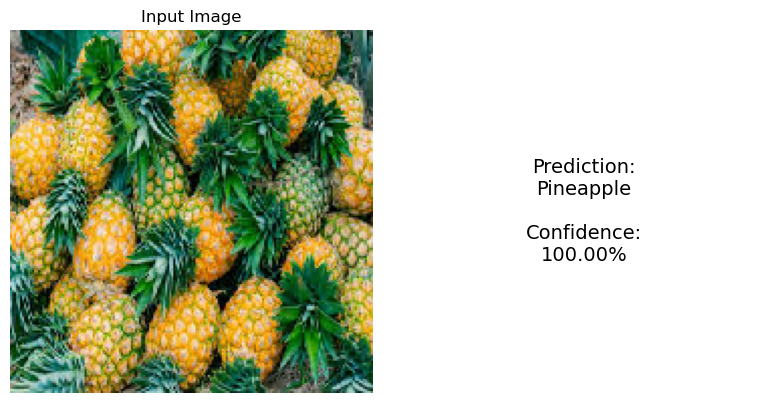

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step


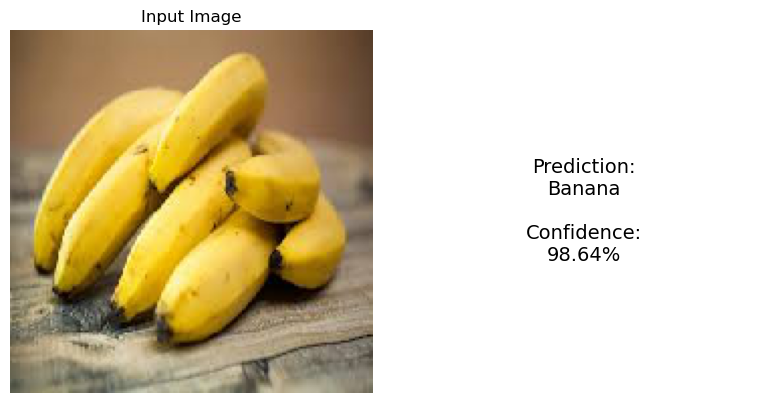

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


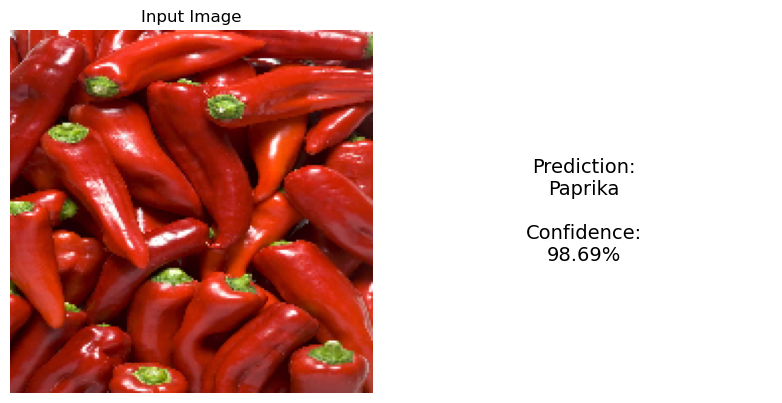

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step


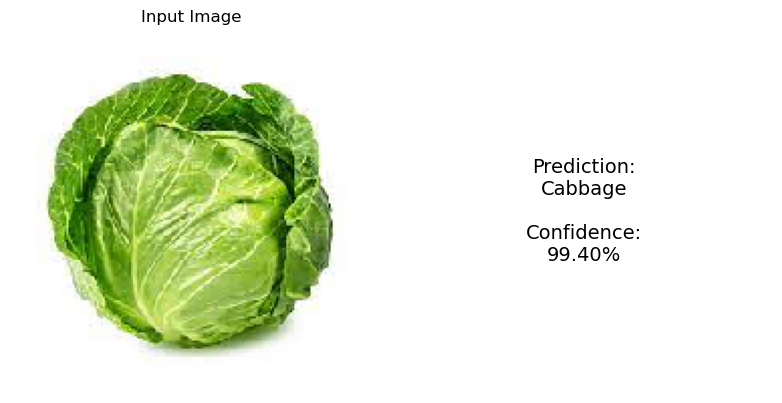

In [269]:
def predict_multiple_images_side_by_side(image_paths, model, class_names):
    import matplotlib.pyplot as plt  # in case not imported
    
    for img_path in image_paths:
        img = tf.keras.utils.load_img(img_path, target_size=(img_height, img_width))
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0)

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])
        predicted_class = class_names[np.argmax(score)]
        confidence = np.max(score) * 100

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))

        ax[0].imshow(img)
        ax[0].axis('off')
        ax[0].set_title('Input Image')

        ax[1].axis('off')
        text = f"Prediction:\n{predicted_class.capitalize()}\n\nConfidence:\n{confidence:.2f}%"
        ax[1].text(0.5, 0.5, text, fontsize=14, ha='center', va='center', wrap=True)

        plt.tight_layout()
        plt.show()

image_list = [
    'sample/sample1.jpg',
    'sample/sample2.jpg',
    'sample/sample3.jpg',
    'sample/sample4.jpg',
    'sample/sample5.jpg',      
    'sample/sample6.jpg'


]

predict_multiple_images_side_by_side(image_list, model, data_cat)